### Lemon quality detection

In [10]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [11]:
# import libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [7]:
image_size= 300
batch_size = 32

In [14]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "lemon_dataset",
    seed = 123,
    shuffle = True,
    batch_size=batch_size,
    image_size=(image_size, image_size),

)

Found 2528 files belonging to 3 classes.


In [22]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [26]:
class_names = dataset.class_names

In [21]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy)

(32, 300, 300, 3)
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 2, 2, 1, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 2, 2, 1, 0, 0,
       2, 0, 0, 2, 2, 1, 2, 0, 0, 0])>>


In [23]:
len(dataset)

79

In [24]:
79*32


2528

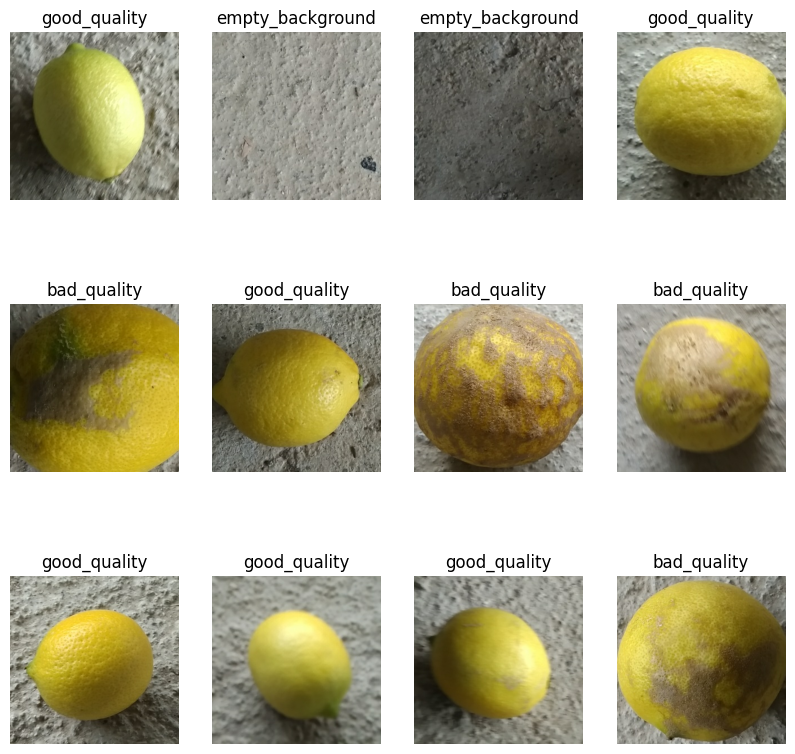

In [27]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
# split the dataset into train test validation

In [28]:
len(dataset)

79

In [29]:
# traning
79*0.8

63.2

In [30]:
100-63.2

36.8

In [32]:
len(dataset.take(63))

63

In [34]:
def split_dataset(dataset, train_split = 0.8, test_split= 0.1, val_split=0.1, shuffle=True, shuffle_size = 10000):
    assert (train_split+test_split+val_split) == 1
    
    ds_size = len(dataset)
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    train_size = int(ds_size*train_split)
    val_size = int(ds_size*val_split)
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size).skip(val_size)
    return train_ds, test_ds, val_ds

In [35]:
train_ds, test_ds,  val_ds = split_dataset(dataset)


In [36]:
len(train_ds)

63

In [37]:
len(test_ds)

9

In [38]:
len(val_ds)

7

In [39]:
# cache, shuffle, prefetch the dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [44]:
# model building

In [49]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size, image_size),
    layers.experimental.preprocessing.Rescaling(1./299),
])

In [53]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
# apply data augmentation in train_ds

In [54]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True),y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [66]:
channel = 3
n_classes = 3

In [55]:
# model architecture

In [67]:
input_shape = (batch_size, image_size, image_size, channel)
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


In [60]:
model.build(input_shape = input_shape)

In [62]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 300, 300, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 298, 298, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 149, 149, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 147, 147, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 73, 73, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 71, 71, 64)         

In [69]:
# compile our model
model.compile(
    optimizer = 'adam',
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [70]:
history = model.fit(
    train_ds,
    batch_size = batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs= 30
)

Epoch 1/30
63/63 [==============================] - 266s 4s/step - loss: 0.6317 - accuracy: 0.6756 - val_loss: 0.4348 - val_accuracy: 0.8259
Epoch 2/30
63/63 [==============================] - 275s 4s/step - loss: 0.3985 - accuracy: 0.8269 - val_loss: 0.3641 - val_accuracy: 0.8438
Epoch 3/30
63/63 [==============================] - 265s 4s/step - loss: 0.3111 - accuracy: 0.8750 - val_loss: 0.1897 - val_accuracy: 0.9062
Epoch 4/30
63/63 [==============================] - 259s 4s/step - loss: 0.1761 - accuracy: 0.9306 - val_loss: 0.4009 - val_accuracy: 0.8259
Epoch 5/30
63/63 [==============================] - 241s 4s/step - loss: 0.1808 - accuracy: 0.9330 - val_loss: 0.1093 - val_accuracy: 0.9554
Epoch 6/30
63/63 [==============================] - 241s 4s/step - loss: 0.1365 - accuracy: 0.9499 - val_loss: 0.0782 - val_accuracy: 0.9643
Epoch 7/30
63/63 [==============================] - 694s 11s/step - loss: 0.0846 - accuracy: 0.9638 - val_loss: 0.0952 - val_accuracy: 0.9554
Epoch 8/30
6

In [71]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 15s 455ms/step - loss: 0.0488 - accuracy: 0.9826


In [72]:
scores

[0.04883866757154465, 0.9826388955116272]

In [73]:
history


In [74]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 63}

In [75]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [77]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [78]:
epochs = 30

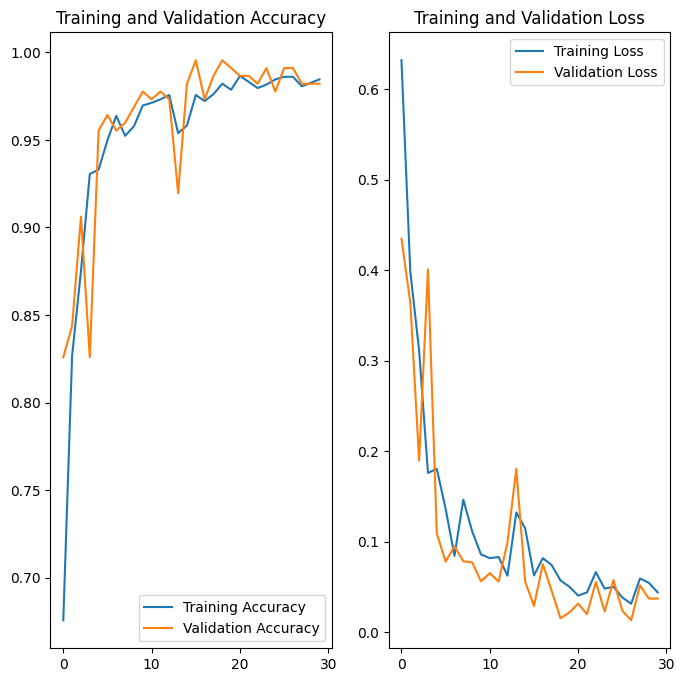

In [79]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label= 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [80]:
# prediction
import numpy as np

first image to predict
actual label good_quality
1/1 [==============================] - 1s 757ms/step
predicted label good_quality


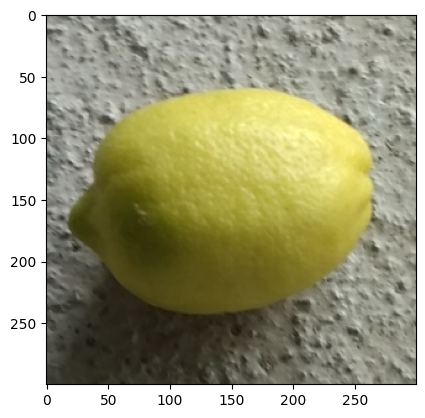

In [84]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label", class_names[np.argmax(batch_prediction[0])])

In [85]:
# save model

In [86]:
model.save("lemon.h5")

C:\Users\shivb\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
